In [9]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
spectra_file = 'ALL_GNPS.mgf'
# spectra_file = "MASSBANK.mgf"  # Smaller set for faster runs

# How many pairs to process and compare from spectra_file
n_spectra = (512 ** 2)

# limits for testing tolerance influence on performance
min_tolerance = 1e-3
max_tolerance = .30 # tolerance at >=.35 causes an OOM

# limits for testing num peaks influence on performance
min_num_peaks = 32
max_num_peaks = 2048

# limits for testing match_limit influence on performance
min_match_limit = 32
max_match_limit = 2048

# Max evals
num_evals = 15

# Default params
default_num_peaks = 1024
# These are specified in the files as default kwargs themselves
# default_tolerance = .1
# default_match_limit = 2048 

# optimal batch size is hardware-dependent, but usually the best number is the largest the hardware can handle (without an OOM error)
batch_size = min(2048, int(n_spectra**.5)) # We have way too few elements for larger batch to be useful

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-ff155de2-7a01-2f4a-25c9-7393317fb5bf)
Number of CPU cores 128


In [2]:
! pip uninstall cudams -q -y
! pip install -q --upgrade git+https://github.com/tornikeo/cosine-similarity@main

In [3]:
from cudams.utils import argbatch, Timer, use_style
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import torch
import matplotlib.pyplot as plt
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from cudams.utils import mute_stdout
from collections import defaultdict
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from cudams.similarity import CudaCosineGreedy
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib

np.random.seed(42)
use_style()
assert cuda.is_available()

/opt/conda/lib/python3.10/site-packages/sparsestack/StackedSparseArray.py:4: DeprecationWarning: Please use `get_index_dtype` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import get_index_dtype


## Default accuracy and performance

In [4]:
def parse_spectrum(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = normalize_intensities(spectrum)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=default_num_peaks) # NOTICE! We cut off smaller peaks, after the largest `max_peaks` - this is required for the GPU
    return spectrum

spectra = []
for i, sp in enumerate(load_from_mgf(download(spectra_file))):
    spectra.append(sp)
    if i > n_spectra: # NOTICE! We don't process all of ALL_GNPS to save time - it takes around 30 mins on this machine.
        break
spectra = Parallel(-1)(
    delayed(parse_spectrum)(spe) for spe in spectra
)
spectra = [sp for sp in spectra if sp is not None]

/opt/conda/lib/python3.10/site-packages/cudams/utils.py:267: UserWarning: As of 2024, ALL_GNPS.mgf is a large file (1.76GB) make sure the machine can handle this
  warnings.warn(
100%|█████████████████████████████████████| 1.89G/1.89G [00:00<00:00, 1.96TB/s]


2024-03-13 08:14:21,611:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-13 08:14:21,612:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-13 08:14:21,768:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-13 08:14:23,337:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-13 08:14:23,339:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-13 08:14:23,339:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-13 08:14:23,346:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-13 08:14:23,347:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-13 08:14:23,347:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H

In [39]:
from cudams.similarity import CudaCosineGreedy
from matchms.similarity import CosineGreedy
np.random.seed(42)
                                                                                    
# jobs = []
# for upscale in np.linspace(.5, 2, num=num_evals):
#     def loop(upscale):

upscale = 2
references = np.random.choice(
    spectra, 
    size=int(n_spectra**.5 * upscale), 
    replace=False, # Just like BLINK, we randomly select without replacement.
)

queries = np.random.choice(
    spectra,
    size=int(n_spectra**.5 * upscale),
    replace=False,
)

kernel = CudaCosineGreedy(
    batch_size = int(batch_size * upscale),
)

# Warm-up kernel. 
scores_cu = kernel.matrix(references[:64], queries[:64])

with Timer() as time:
    scores_cu = kernel.matrix(references, queries)
nelem = scores_cu['score'].size
thrp_cu = scores_cu['score'].size / time.duration
print(f"CudaCosineGreedy throughput {thrp_cu:.3e} elems/sec")

kernel = CosineGreedy()
with Timer() as time:
    scores = kernel.matrix(references, queries)
thrp = scores['score'].size / time.duration
print(f"CosineGreedy throughput {thrp:.3e} elems/sec")

#         return nelem, (scores, scores_cu, thrp, thrp_cu)
#     jobs.append(delayed(loop)(upscale))
    
# # Limit number of jobs, so that CUDA doesn't OOM
# # We could also limit match_limit, but that wouldn't
# # be a fair comparison
# data = Parallel(4)(jobs)

100%|██████████| 1/1 [00:08<00:00,  8.48s/it]


CudaCosineGreedy throughput 1.227e+05 elems/sec
CosineGreedy throughput 1.459e+04 elems/sec


In [37]:
# bar_df = pd.DataFrame(
#     data,
# )
# bar_df.
# # bar_df.columns = ['# comparisons', 'Matchms', 'CudaCosineGreedy' ]

CudaCosineGreedy throughput 1.005e+05 elems/sec
CosineGreedy throughput 1.396e+04 elems/sec


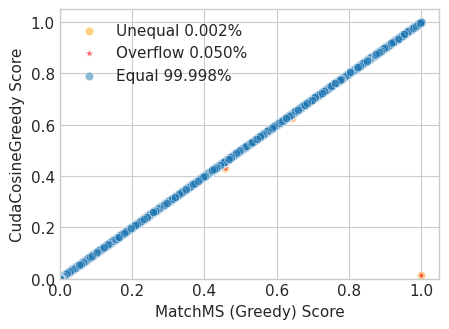

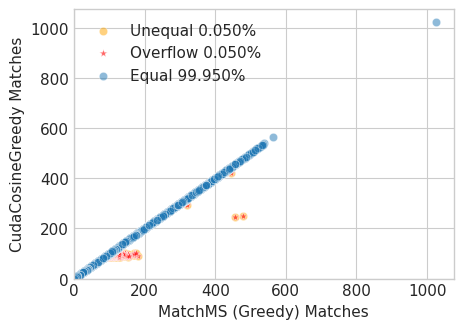

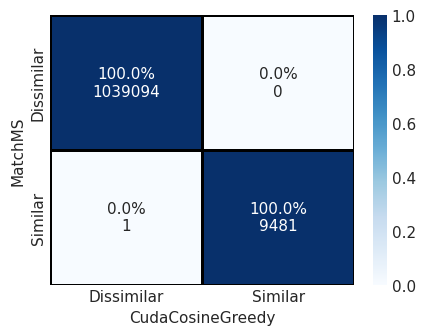

In [42]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib

# plt.figure()
# sns.barplot(
#     x=['Matchms (greedy)', 'CudaCosineGreedy'],
#     y=[thrp, thrp_cu],
#     hue=['gray', 'blue',],
# )
# plt.xlabel("Method")
# plt.ylabel("Throughput (it/sec)")

# We use largest batch size for best error estimates
for key in ['score','matches']:
    a = scores[key].ravel()
    ov = scores_cu['overflow'].ravel() == 1
    b = scores_cu[key].ravel()
    iseq = np.isclose(a,b,atol=.001)


    plt.figure()
    sns.scatterplot(x=a[~iseq],
                    y=b[~iseq], c='orange', alpha=.5, 
                    label=f'Unequal {(~iseq).mean()*100:.3f}%')
    sns.scatterplot(x=a[ov],
                    y=b[ov], marker='*', c='red', 
                    alpha=.6, label=f'Overflow {ov.mean()*100:.3f}%')
    sns.scatterplot(x=a[iseq], y=b[iseq], 
                    alpha=.5, 
                    label=f'Equal {iseq.mean()*100:.3f}%')
    
    plt.xlabel(f"MatchMS (Greedy) {key.capitalize()}")
    plt.ylabel(f"CudaCosineGreedy {key.capitalize()}")
    plt.ylim([0, None])
    plt.xlim([0, None])
    plt.show()


# Same thresholds as in BLINK
a_sim = scores['score'] >= .7 
b_sim = scores_cu['score'] >= .7

a_sim *= scores['matches'] >= 6
b_sim *= scores_cu['matches'] >= 6

plt.figure()
cm = confusion_matrix(a_sim.ravel(), b_sim.ravel())
cm_norm = cm / cm.astype(float).sum(axis=0)
df = pd.DataFrame(cm)

perc = pd.DataFrame(data=cm_norm * 100)

annot = perc.round(2).astype(str) + "%" + "\n" + df.round(2).astype(str) 
sns.heatmap(cm_norm, annot=annot, fmt='', vmin=0, vmax=1, cmap="Blues", 
                 linewidth=1, linecolor='black', xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'])
plt.xlabel('CudaCosineGreedy')
plt.ylabel('MatchMS')
plt.show()

## Tolerance vs performance

In [44]:
np.random.seed(123)

references = np.random.choice(
    spectra, 
    size=int(n_spectra**.5), 
    replace=False, # Just like BLINK, we randomly select without replacement.
)

queries = np.random.choice(
    spectra,
    size=int(n_spectra**.5),
    replace=False,
)

tolerances = np.logspace(
    np.log10(min_tolerance),
    np.log10(max_tolerance), 
    num=num_evals
)

jobs = []
for tolerance in tolerances:
    def loop(tolerance):
        tolerance = float(tolerance) # one of numba's many quirks
        kernel = CosineGreedy(
            tolerance=tolerance
        )
        scores = kernel.matrix(references, queries)
        
        kernel = CudaCosineGreedy(
            tolerance=tolerance,
            batch_size=batch_size,
            verbose=True,
        )
        scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, kernel.kernel_time
    jobs.append(delayed(loop)(tolerance))
    
data = Parallel(4)(jobs)

100%|██████████| 1/1 [00:14<00:00, 14.56s/it]


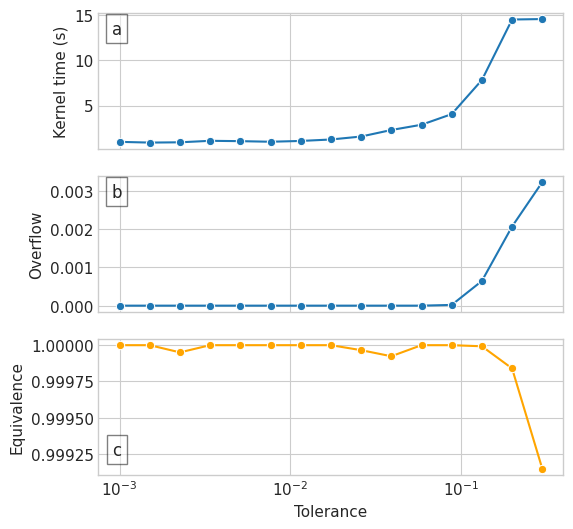

In [45]:
ov_means = []
match_means = []
iseq_means = []
kernel_times = []
for tolerance, (scores, scores_cu, kernel_time) in zip(tolerances, data):
    a = scores['score'].ravel()
    am = scores['matches'].ravel()
    ov = scores_cu['overflow'].ravel() == 1
    b = scores_cu['score'].ravel()
    bm = scores_cu['matches'].ravel()
    iseq = np.isclose(a,b,atol=.001)
    
    ov_means.append(ov.mean())
    iseq_means.append(iseq.mean())
    match_means.append(bm.mean())
    kernel_times.append(kernel_time)

fig, axs = plt.subplot_mosaic(
    [['a'], ['b'], ['c']], 
    # layout='constrained',
    sharex=True,
    figsize=(6,6)
)

ax = axs['a']
sns.lineplot(x=tolerances, 
             y=kernel_times,
             marker='o',
             ax=ax)
ax.text(.05, 0.95, 'a', transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel("Kernel time (s)")

ax = axs['b']
sns.lineplot(x=tolerances, 
             y=ov_means,
             marker='o',
             ax=ax)

ax.text(.05, 0.95, 'b', transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel("Overflow")

ax = axs['c']
sns.lineplot(x=tolerances,
             y=iseq_means, 
             marker='o',
             color='orange',
             ax=ax)
# thresh_idx = np.searchsorted(iseq_means, .999)
ax.set_ylabel(r"Equivalence")

ax.set_xscale('log')
ax.set_xlabel("Tolerance")
ax.text(.05, 0.25, 'c', transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()

## Match limit vs performance

In [46]:
np.random.seed(111)

match_limits = np.logspace(
    np.log10(min_match_limit),
    np.log10(max_match_limit), 
    num=num_evals
)
references = np.random.choice(
    spectra, 
    size=int(n_spectra**.5), 
    replace=False, # Just like BLINK, we randomly select without replacement.
)

queries = np.random.choice(
    spectra,
    size=int(n_spectra**.5),
    replace=False,
)

jobs = []
for match_limit in match_limits:
    def loop(match_limit):
        match_limit = int(match_limit) # one of numba's many quirks
        kernel = CosineGreedy()
        scores = kernel.matrix(references, queries)
        kernel = CudaCosineGreedy(
            batch_size=batch_size,
            match_limit=match_limit,
            verbose=True,
        )
        scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, kernel.kernel_time
    jobs.append(delayed(loop)(match_limit))
data = Parallel(4)(jobs)

100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


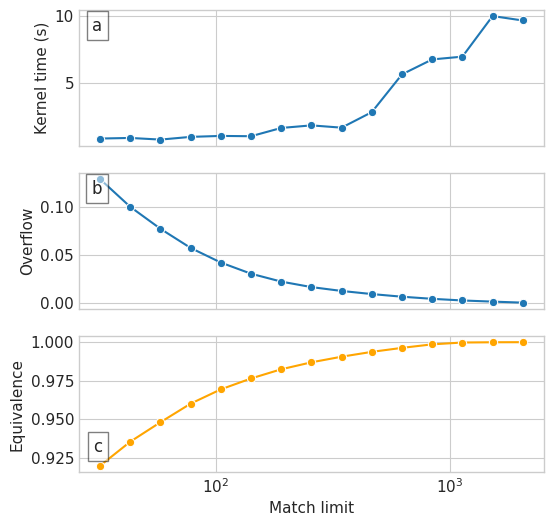

In [47]:
ov_means = []
match_means = []
iseq_means = []
kernel_times = []
for match_limit, (scores, scores_cu, kernel_time) in zip(match_limits, data):
    a = scores['score'].ravel()
    am = scores['matches'].ravel()
    ov = scores_cu['overflow'].ravel() == 1
    b = scores_cu['score'].ravel()
    bm = scores_cu['matches'].ravel()
    iseq = np.isclose(a,b,atol=.001)
    
    ov_means.append(ov.mean())
    iseq_means.append(iseq.mean())
    match_means.append(bm.mean())
    kernel_times.append(kernel_time)

fig, axs = plt.subplot_mosaic(
    [['a'], ['b'], ['c']], 
    # layout='constrained',
    sharex=True,
    figsize=(6,6)
)

ax = axs['a']
sns.lineplot(x=match_limits, 
             y=kernel_times,
             marker='o',
             ax=ax)
ax.text(.05, 0.95, 'a', transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel("Kernel time (s)")

ax = axs['b']
sns.lineplot(x=match_limits, 
             y=ov_means,
             marker='o',
             ax=ax)

ax.text(.05, 0.95, 'b', transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel("Overflow")

ax = axs['c']
sns.lineplot(x=match_limits,
             y=iseq_means, 
             marker='o',
             color='orange',
             ax=ax)
# thresh_idx = np.searchsorted(iseq_means, .999)
ax.set_ylabel(r"Equivalence")

ax.set_xscale('log')
ax.set_xlabel("Match limit")
ax.text(.05, 0.25, 'c', transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()